In [1]:
import torch
from torchvision import datasets, transforms
from torcheval.metrics import BinaryAccuracy
import numpy as np
from PIL import Image

data_train = datasets.MNIST(root="./dataset",train=True,download=True,transform=transforms.ToTensor())
data_test = datasets.MNIST(root="./dataset",train=False,download=True,transform=transforms.ToTensor())

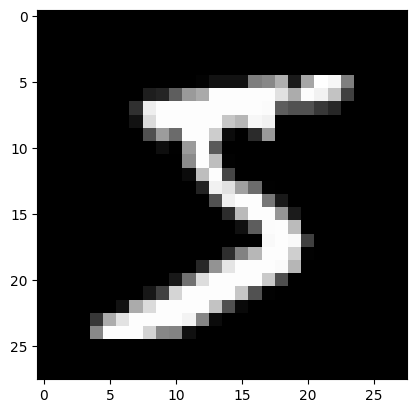

In [2]:
from matplotlib import pyplot as plt

image, label = data_train[0]

plt.imshow(image.squeeze().numpy(),cmap='gray')
plt.show()

In [3]:
train_dataset = []

for x , y in data_train:

    list = [0,0,0,0,0,0,0,0,0,0]

    list[y] = 1
    
    y = np.array(list)

    x = x.squeeze().reshape(-1).numpy()

    train_dataset.append([x,y])

test_dataset = []

for x , y in data_test:

    list = [0,0,0,0,0,0,0,0,0,0]

    list[y] = 1
    
    y = np.array(list)

    x = x.squeeze().reshape(-1).numpy()

    test_dataset.append([x,y])

In [4]:
from torch.utils.data import dataset, DataLoader

train_dataloader = DataLoader(train_dataset,batch_size=600,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=100,shuffle=True)

In [5]:
import torch.nn as nn

class UnKownSoftMaxNet(nn.Module):
    
    def __init__(self):
        super(UnKownSoftMaxNet, self).__init__()
        
        self.fc1 = nn.Linear(784,10)
        self.activation = nn.Softmax(1)
        
    def forward(self,input):
        
        rfc1 = self.fc1(input)
        
        output = self.activation(rfc1)
        
        return output
    
net = UnKownSoftMaxNet()

In [6]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.01)

loss_fc = nn.CrossEntropyLoss()

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [8]:
def resize_tensor(tensor):
    
    v_min, v_max = tensor.min(), tensor.max()
    
    new_min,new_max = 0,255
    
    v_p = (tensor - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
    
    return v_p
    

In [9]:
from torcheval.metrics import MulticlassAccuracy

In [10]:
epochs = 2000

for epoch in range(1,epochs+1):

    loss_sum = 0.0

    metric = MulticlassAccuracy()

    for (train_features,train_labels),(test_features,test_labels) in zip(train_dataloader,test_dataloader) :

        epoch_y = net(train_features)
        loss = loss_fc(epoch_y.to(torch.float32),train_labels.to(torch.float32))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0 :
            for m in net.modules():
                if isinstance(m,nn.Linear):
                    
                    img_tensor = m.weight.clone().detach()
                    img = resize_tensor(img_tensor.squeeze())
                    
                    img = img.reshape(10,28,28)
                    np_arr = np.array(img,dtype=np.uint8)
                                        
                    for img_num ,i in zip(np_arr,range(len(np_arr))):
                        writer.add_image(f'weight_to_img_{i}',img_num,epoch + 1,dataformats='WH')

        loss_sum += loss
        
        epoch_test_y = net(test_features)
        result_set = []
        gt_set = []
        
        for result , gt in zip(epoch_test_y, test_labels):
            
            pre_max = 0
            temp = -1
            
            for pre_data,i in zip(result,range(len(result))):
                
                if pre_data > pre_max:
                    temp = i
                    pre_max = pre_data
            
            if temp != -1:
                result_set.append(temp)
            
            for gt_data,i in zip(gt,range(len(gt))):
                
                if gt_data == 1:
                    gt_set.append(i)
                
        gt_set = np.array(gt_set)
        gt_set = torch.tensor(gt_set)
        
        result_set = np.array(result_set)
        result_set = torch.tensor(result_set)
        metric.update(result_set,gt_set)
        
    acc = metric.compute()

    loss = loss_sum / len(train_dataloader)

    print('Epoch {:4d}/{} train_loss: {:.6f} acc: {:.6f}'.format(
        epoch+1, epochs, loss, acc
    ))

    if loss < 0.1 :
        break

Epoch    2/2000 train_loss: 2.293874 acc: 0.170400
Epoch    3/2000 train_loss: 2.276844 acc: 0.264500
Epoch    4/2000 train_loss: 2.253322 acc: 0.260600
Epoch    5/2000 train_loss: 2.229254 acc: 0.342300
Epoch    6/2000 train_loss: 2.205744 acc: 0.473500
Epoch    7/2000 train_loss: 2.179636 acc: 0.560200
Epoch    8/2000 train_loss: 2.149758 acc: 0.596900
Epoch    9/2000 train_loss: 2.117160 acc: 0.604700
Epoch   10/2000 train_loss: 2.084366 acc: 0.609600
Epoch   11/2000 train_loss: 2.053657 acc: 0.623500
Epoch   12/2000 train_loss: 2.025968 acc: 0.643400
Epoch   13/2000 train_loss: 2.001244 acc: 0.665800
Epoch   14/2000 train_loss: 1.979060 acc: 0.691300
Epoch   15/2000 train_loss: 1.958950 acc: 0.714700
Epoch   16/2000 train_loss: 1.940591 acc: 0.733800
Epoch   17/2000 train_loss: 1.923859 acc: 0.746300
Epoch   18/2000 train_loss: 1.908713 acc: 0.756800
Epoch   19/2000 train_loss: 1.895064 acc: 0.764700
Epoch   20/2000 train_loss: 1.882762 acc: 0.768300
Epoch   21/2000 train_loss: 1.8

In [32]:
x = torch.tensor([test_dataset[40][0]])

pre_y = net(x)

pre_y = pre_y.squeeze()

pre_max = 0
temp = -1

for pre_data,i in zip(pre_y,range(len(pre_y))):
    
    if pre_data > pre_max:
        temp = i
        pre_max = pre_data
temp



1

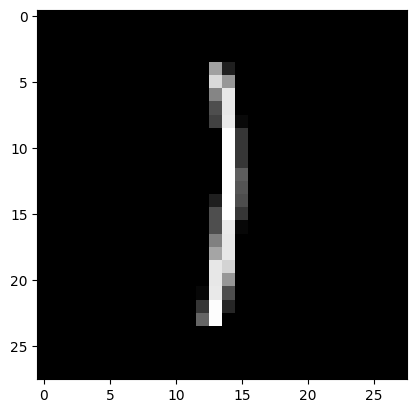

In [33]:
from matplotlib import pyplot as plt

plt.imshow(x.squeeze().reshape(28,28).numpy(),cmap='gray')
plt.show()